In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2023-02-05 08:44:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  57.2MB/s    in 0.5s    

2023-02-05 08:44:59 (57.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [2]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [34]:
# 50
import collections
import csv
import random

TARGET_PUBLISHERS = [
  'Reuters',\
  'Huffington Post',\
  'Businessweek',\
  'Contactmusic.com',\
  'Daily Mail'
]

CATEGORIES = [
    'b',
    't',
    'e',
    'm'
]

with open('./newsCorpora.csv') as f:
  reader = csv.reader(f, delimiter='\t')
  all_news = [[news[4], news[1]] for news in reader if news[3] in TARGET_PUBLISHERS]

random.shuffle(all_news)

train_data_num = len(all_news)  * 8 // 10
valid_data_num = len(all_news)  * 9 // 10
train_data = all_news[: train_data_num]
valid_data = all_news[train_data_num : valid_data_num]
test_data = all_news[valid_data_num :]

def write_newsfile(path, data):
  with open(path, mode='w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(data)

write_newsfile('./train.txt', train_data)
write_newsfile('./valid.txt', valid_data)
write_newsfile('./test.txt', test_data)

def calculate_categories(name, data):
  print(f'{name}データ事例数: {len(data)}')
  train_categories = [news[0] for news in data]
  train_c = collections.Counter(train_categories)
  for category in CATEGORIES:
    num = train_c[category]
    print(f'Category {category}: {num}')

calculate_categories('学習', train_data)
calculate_categories('評価', test_data)

学習データ事例数: 10672
Category b: 4511
Category t: 1188
Category e: 4239
Category m: 734
評価データ事例数: 1334
Category b: 558
Category t: 168
Category e: 513
Category m: 95


In [ ]:
!pip install nltk

In [105]:
# 51
import nltk
from nltk.corpus import wordnet as wn

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_sentence(sentence):
  morph = nltk.word_tokenize(sentence)
  processed_sentence = []
  for s_pos in nltk.pos_tag(morph):
    if len(s_pos[1]) >= 2 and s_pos[1] != 'SYM':
      processed_sentence.append(s_pos[0])
  return processed_sentence

def retrieve_feature(file_type):
  with open(f'./{file_type}.txt', mode='r') as f:
    reader = csv.reader(f, delimiter='\t')
    with open(f'./{file_type}.feature.txt', mode='w') as f:
      writer = csv.writer(f, delimiter='\t')
      for row in reader:
        category, title = row
        processed_sentence = preprocess_sentence(title)
        writer.writerow([category, ' '.join(processed_sentence)])

retrieve_feature('train')
retrieve_feature('valid')
retrieve_feature('test')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [108]:
# 52, 53, 54, 55

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

SEED = 0

vec_tfidf = TfidfVectorizer()

def format_data(file_type):
  with open(f'./{file_type}.feature.txt', mode='r') as f:
    reader = csv.reader(f, delimiter='\t')
    X = []
    Y = []
    for news in reader:
      category, title = news
      X.append(title)
      Y.append(category)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


Xtrain, Ytrain = format_data('train')
Xtest, Ytest = format_data('test')
Xtrain = vec_tfidf.fit_transform(Xtrain)
Xtest = vec_tfidf.transform(Xtest)
lr = LogisticRegression(random_state=SEED, n_jobs=-1)
lr.fit(Xtrain, Ytrain)
Ypred = lr.predict(Xtest)
cm = confusion_matrix(Ytest, Ypred)

print('Accuracy rate: {}'.format(sum([cm[i][i] for i in range(len(CATEGORIES))]) / np.sum(cm)))
pd.DataFrame(cm,
             columns=[f'Predicted {CATEGORY}' for CATEGORY in CATEGORIES],
             index=[f'Actual {CATEGORY}' for CATEGORY in CATEGORIES])

Accuracy rate: 0.8770614692653673


,Predicted b,Predicted t,Predicted e,Predicted m
Actual b,523,21,3,11
Actual t,9,501,0,3
Actual e,15,28,52,0
Actual m,38,36,0,94


In [109]:
# 56

row_sums = np.sum(cm, axis=0)
column_sums = np.sum(cm, axis=1)
precisions = [cm[i][i] / row_sums[i] for i in range(len(CATEGORIES))]
accuracies = [cm[i][i] / column_sums[i] for i in range(len(CATEGORIES))]
F1s = [2 * precisions[i] * accuracies[i] / (precisions[i] + accuracies[i]) for i in range(len(CATEGORIES))]

macro_prec_avg = sum(precisions) / len(CATEGORIES)
macro_acc_avg = sum(accuracies) / len(CATEGORIES)
macro_F1_avg = sum(F1s) / len(CATEGORIES)

micro_prec_avg = sum([cm[i][i] for i in range(len(CATEGORIES))]) / sum([row_sums[i] for i in range(len(CATEGORIES))])
micro_acc_avg = sum([cm[i][i] for i in range(len(CATEGORIES))]) / sum([column_sums[i] for i in range(len(CATEGORIES))])

print(f'Macro P: {macro_prec_avg}')
print(f'Macro R: {macro_acc_avg}')
print(f'Macro F1: {macro_F1_avg}')

print(f'Micro P: {micro_prec_avg}')
print(f'Micro R: {micro_acc_avg}')

Macro P: 0.8911977038256901
Macro R: 0.7551941008435066
Macro F1: 0.8003415763143149
Micro P: 0.8770614692653673
Micro R: 0.8770614692653673


In [110]:
# 57
print('Top10: {}'.format(np.sort(lr.coef_.ravel())[-10:]))
print('Worst10: {}'.format(np.sort(lr.coef_.ravel())[:10]))


Top10: [3.42027211 3.51216516 3.80779643 3.90963204 3.95099391 3.96872017
 4.70197384 4.73831177 4.89301515 5.60654242]
Worst10: [-3.65421856 -2.94226065 -2.86468711 -2.39312616 -2.23663201 -2.1984696
 -2.12478733 -2.11282431 -2.05598085 -2.04868052]


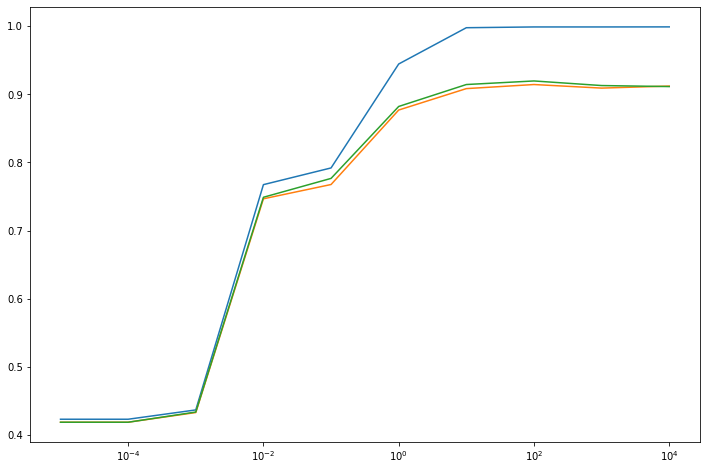

In [112]:
# 58
import matplotlib.pyplot as plt


Xtrain, Ytrain = format_data('train')
Xtest, Ytest = format_data('test')
Xvalid, Yvalid = format_data('valid')
vec_tfidf = TfidfVectorizer()

Xtrain = vec_tfidf.fit_transform(Xtrain)
Xtest = vec_tfidf.transform(Xtest)
Xvalid = vec_tfidf.transform(Xvalid)

def training_model(Xtrain, Ytrain, Xtest, Ytest, Xvalid, Yvalid, C):
  lr = LogisticRegression(C=C, random_state=SEED, penalty='l2', n_jobs=-1)
  lr.fit(Xtrain, Ytrain)

  r_rate_train = calculate_r_rate(lr, Xtrain, Ytrain)
  r_rate_test = calculate_r_rate(lr, Xtest, Ytest)
  r_rate_valid = calculate_r_rate(lr, Xvalid, Yvalid)
  
  return r_rate_train, r_rate_test, r_rate_valid

def calculate_r_rate(lr, X, Y):
  Ypred = lr.predict(X)
  cm = confusion_matrix(Y, Ypred)
  r_rate = sum([cm[i][i] for i in range(len(CATEGORIES))]) / np.sum(cm)
  return r_rate

regularization_strengths = [10 ** i for i in range(-5, 5)]
r_rates_train = []
r_rates_test = []
r_rates_valid = []
for i in regularization_strengths:
  r_rate_train, r_rate_test, r_rate_valid = training_model(Xtrain, Ytrain, Xtest, Ytest, Xvalid, Yvalid, i)
  r_rates_train.append(r_rate_train)
  r_rates_test.append(r_rate_test)
  r_rates_valid.append(r_rate_valid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
plt.plot(regularization_strengths, r_rates_train)
plt.plot(regularization_strengths, r_rates_test)
plt.plot(regularization_strengths, r_rates_valid)
ax.set_xscale('log')
plt.show()

In [113]:
# 59
## RandomSearch
from sklearn.model_selection import RandomizedSearchCV

estimator = LogisticRegression(random_state=SEED, n_jobs=-1)
param_distributions = {
    'C': list(range(1, 100, 10))
}
n_iter = 10
cv = 5
tuned_model = RandomizedSearchCV(estimator=estimator, 
                           param_distributions=param_distributions,
                           n_iter=n_iter, 
                           random_state=SEED,
                           cv=cv, return_train_score=False)

tuned_model.fit(Xtrain, Ytrain)


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(n_jobs=-1, random_state=0),
                   param_distributions={'C': [1, 11, 21, 31, 41, 51, 61, 71, 81,
                                              91]},
                   random_state=0)

In [114]:
best_parameter = tuned_model.best_params_['C']
print(training_model(Xtrain, Ytrain, Xtest, Ytest, Xvalid, Yvalid, best_parameter))

(0.9990629685157422, 0.9130434782608695, 0.9190404797601199)


In [115]:
## Optuna
!pip install optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.7 MB/s eta 0:00:00


In [116]:
import optuna
from sklearn.model_selection import cross_val_score

      
def objective(trial, x, t, cv):
    C = trial.suggest_int('C', 1, 100)

    estimator = LogisticRegression(
      C = C,
      random_state=SEED,
      n_jobs=-1
    )

    print('Current_params : ', trial.params)
    accuracy = cross_val_score(estimator, x, t, cv=cv).mean()
    return accuracy

study = optuna.create_study(direction='maximize')
cv = 5
study.optimize(lambda trial: objective(trial, Xtrain, Ytrain, cv), n_trials=10)


[I 2023-02-05 10:03:20,085] A new study created in memory with name: no-name-1b851d6e-a9ff-4009-b98a-c2be790b93e3


Current_params :  {'C': 25}


[I 2023-02-05 10:03:29,697] Trial 0 finished with value: 0.9077964219319636 and parameters: {'C': 25}. Best is trial 0 with value: 0.9077964219319636.


Current_params :  {'C': 54}


[I 2023-02-05 10:03:40,613] Trial 1 finished with value: 0.908452335226038 and parameters: {'C': 54}. Best is trial 1 with value: 0.908452335226038.


Current_params :  {'C': 90}


[I 2023-02-05 10:03:49,816] Trial 2 finished with value: 0.9090145717051243 and parameters: {'C': 90}. Best is trial 2 with value: 0.9090145717051243.


Current_params :  {'C': 94}


[I 2023-02-05 10:03:55,663] Trial 3 finished with value: 0.9091084241092691 and parameters: {'C': 94}. Best is trial 3 with value: 0.9091084241092691.


Current_params :  {'C': 6}


[I 2023-02-05 10:04:01,478] Trial 4 finished with value: 0.9043300285990838 and parameters: {'C': 6}. Best is trial 3 with value: 0.9091084241092691.


Current_params :  {'C': 83}


[I 2023-02-05 10:04:07,144] Trial 5 finished with value: 0.9094832630610897 and parameters: {'C': 83}. Best is trial 5 with value: 0.9094832630610897.


Current_params :  {'C': 86}


[I 2023-02-05 10:04:12,751] Trial 6 finished with value: 0.9086399083424604 and parameters: {'C': 86}. Best is trial 5 with value: 0.9094832630610897.


Current_params :  {'C': 56}


[I 2023-02-05 10:04:18,411] Trial 7 finished with value: 0.9085461437328938 and parameters: {'C': 56}. Best is trial 5 with value: 0.9094832630610897.


Current_params :  {'C': 74}


[I 2023-02-05 10:04:24,099] Trial 8 finished with value: 0.9094830435746439 and parameters: {'C': 74}. Best is trial 5 with value: 0.9094832630610897.


Current_params :  {'C': 52}


[I 2023-02-05 10:04:29,912] Trial 9 finished with value: 0.9083588778974953 and parameters: {'C': 52}. Best is trial 5 with value: 0.9094832630610897.


In [117]:
best_parameter = study.best_params['C']
print(training_model(Xtrain, Ytrain, Xtest, Ytest, Xvalid, Yvalid, best_parameter))

(0.9991566716641679, 0.9145427286356822, 0.9197901049475262)
